In [1]:
from itertools import product
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from torch import nn, autograd
import optimizers
import math
from tqdm import tqdm

# Configurations

In [2]:
np.random.seed(0)
torch.manual_seed(0)

BLUE = '#7DB1F1'
RED = '#FC82AB'
GREEN = '#7FD97B'
YELLOW = '#FFC000'
GREY = '#A5A5A5'
COLORS = [BLUE, RED, YELLOW, GREEN, GREY]

# game settings
LR = 0.1
N = 2000
EPS = 0.02

# sample a matrix
A = (torch.eye(N, dtype=torch.float64) + EPS * torch.randn(N, N, dtype=torch.float64)).cuda()
smax = A.svd()[1][0].cpu().numpy()
smin = A.svd()[1][-1].cpu().numpy()
sis = A.svd()[1].cpu().numpy()
print('A conditioning: {}, smax: {}, smin: {}'.format(smax/smin, smax, smin))
#assert np.isclose(smax, 1.47123122215271)
#assert np.isclose(smin, 0.5847105979919434)

def spow(z, k):
    #modulus = abs(z)
    #theta = np.angle(z)
    #return (modulus ** k) * np.cos(k * theta) + np.sin(k * theta) * 1j
    return z ** k

def gd_alt_radius(k, alpha):
    return abs(1- alpha + alpha * spow(
        1 - LR**2 * sis**2 / 2 + LR * sis * np.sqrt(1- LR**2 * sis**2 / 4) * 1j
    , k)).max()

def gd_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(1 + LR * sis * 1j, k)).max()

def pp_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow((1+LR*sis*1j)/(1+LR**2*sis**2), k)).max()

def eg_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(1- LR*sis + LR*sis*1j, k)).max()

gd_alt_ro = gd_alt_radius(1, 1)
gd_sim_ro = gd_sim_radius(1, 1)
pp_sim_ro = pp_sim_radius(1, 1)
eg_sim_ro = eg_sim_radius(1, 1)
print(f'gd_alt_ro: {gd_alt_ro}')
print(f'gd_sim_ro: {gd_sim_ro}')
print(f'pp_sim_ro: {pp_sim_ro}')
print(f'eg_sim_ro: {eg_sim_ro}')

A conditioning: 56.84369845099666, smax: 2.411884103510685, smin: 0.04243010516970323
gd_alt_ro: 1.0
gd_sim_ro: 1.0286748024947805
pp_sim_ro: 0.9999909985524171
eg_sim_ro: 0.9957660293676189


In [3]:
GD_SIM_BETA1 = NotImplemented
GD_SIM_BETA2 = NotImplemented
print(f'GD_SIM BETAS: {GD_SIM_BETA1, GD_SIM_BETA2}')

PP_SIM_BETA1 = 1
PP_SIM_BETA2 = 1442.94
print(f'PP_SIM BETAS: {PP_SIM_BETA1, PP_SIM_BETA2}')

EG_SIM_BETA1 = 302.85
EG_SIM_BETA2 = 1108.05
print(f'EG_SIM BETAS: {EG_SIM_BETA1, EG_SIM_BETA2}')

C = {
    'GD_SIM': lambda k: min(
        (2 * np.cos(np.angle(1-spow(1+LR*sis*1j, k))) / abs(1-spow(1+LR*sis*1j, k)))
    ),
    'PP_SIM': lambda k: max(
        (
            np.cos(np.angle(1-((1+LR*sis*1j)/(1+LR**2*sis**2))**k)) - 
            np.sqrt(
                1/(1+LR**2*smin**2)**k - 
                np.sin(np.angle(
                    1-spow((1+LR*sis*1j)/(1+LR**2*sis**2), k)
                )) ** 2
            )
        ) /  abs(1-((1+LR*sis*1j)/(1+LR**2*sis**2))**k)
    ),
    'EG_SIM': lambda k:  max(
        (
            np.cos(np.angle(1-spow(1-LR*sis+LR*sis*1j, k))) -
            np.sqrt(
                (1-2*LR*smin+2*LR**2*smin**2)**k -
                np.sin(np.angle(
                    1-spow(1-LR*sis+LR*sis*1j, k)
                )) ** 2
            )
        ) / abs(1-spow(1-LR*sis+LR*sis*1j, k))
    )
}

GD_SIM BETAS: (NotImplemented, NotImplemented)
PP_SIM BETAS: (1, 1442.94)
EG_SIM BETAS: (302.85, 1108.05)


# GD_ALT

<ipython-input-4-1223bcd40c4c>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


rmin: 0.9999922925223799, rmax: 0.9999999853028658


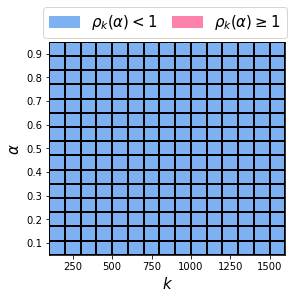

In [4]:
GD_ALT_KS = list(range(100, 1600+1, 100))
GD_ALT_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_ALT_HPS = np.meshgrid(GD_ALT_KS, GD_ALT_ALPHAS)

# compute
gd_alt_radii = np.array([
    gd_alt_radius(k, alpha) for
    (k, alpha) in zip(GD_ALT_HPS[0].flatten(), GD_ALT_HPS[1].flatten())
]).reshape(GD_ALT_HPS[0].shape)

# and plot (matplotlib choses the first color when there is only one value)
cmap = matplotlib.colors.ListedColormap([COLORS[0], COLORS[1]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_ALT_HPS[0], GD_ALT_HPS[1], gd_alt_radii < 1, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

#
handles, labels = plt.gca().get_legend_handles_labels()
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 6', linewidth=3)

handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./appendix_bilinear_sweep_gd_alt.png', format='png', dpi=200)
print(f'rmin: {gd_alt_radii.min()}, rmax: {gd_alt_radii.max()}')

# GD_SIM

<ipython-input-5-07b302e35f6a>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


beta1: NotImplemented, beta2: NotImplemented
=> c: [-9.167601066241621, -19.054825769768552, -26.454835698453618, -25.6389098887009, -17.792162780586747, -43.8122430356684, -16.711110760040402, -32.30715769415536, -20.716670632867, -26.03239553710036, -12.701939555977587, -21.41439760567087, -13.035582644728803, -13.625387034331638, -7.378518304550527, -15.670372870013587]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]
=> k: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]


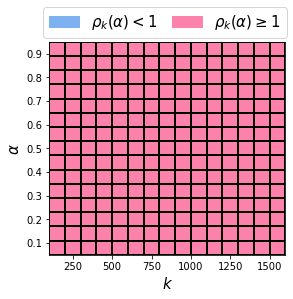

In [5]:
GD_SIM_KS = list(range(100, 1600+1, 100))
GD_SIM_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_SIM_HPS = np.meshgrid(GD_SIM_KS, GD_SIM_ALPHAS)

gd_sim_improvements = np.array([
    1 > gd_sim_radius(k, alpha) for
    (k, alpha) in zip(GD_SIM_HPS[0].flatten(), GD_SIM_HPS[1].flatten())
]).reshape(GD_SIM_HPS[0].shape)
gd_sim_cs = [C['GD_SIM'](k) for k in GD_SIM_KS]

edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_SIM_HPS[0], GD_SIM_HPS[1], gd_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 7', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./appendix_bilinear_sweep_gd_sim.png', format='png', dpi=200)
print(f'beta1: {GD_SIM_BETA1}, beta2: {GD_SIM_BETA2}')
print(f'=> c: {gd_sim_cs}')
print(f'=> a: {GD_SIM_ALPHAS}')
print(f'=> k: {GD_SIM_KS}')

# PP_SIM

<ipython-input-6-4ccfca83832a>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


=> beta1: 1, beta2: 1442.94
=> c: [0.010151369948112766, 0.019224770081775915, 0.04234457171036561, 0.07458936960586511, 0.11450785298575601, 0.16463231363665964, 0.20624783744029823, 0.28809996792652, 0.3603995288679389, 0.45646732863671546, 0.28542389023560144, 0.17740184977262924, 0.2698451422576633, 0.5968089322743371, 1.0000000000087204, 0.2871426052573336]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]
=> k: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]


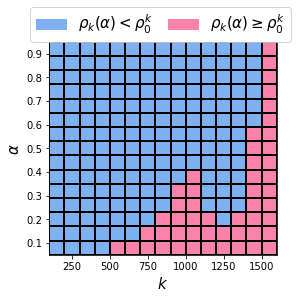

In [6]:
PP_SIM_KS = list(range(100, 1600 + 1, 100))
PP_SIM_ALPHAS = list(reversed([x/1000 for x in range(50, 950 + 1, 900 // 15)]))
PP_SIM_HPS = np.meshgrid(PP_SIM_KS, PP_SIM_ALPHAS)

# compute
pp_sim_improvements = np.array([
    pp_sim_radius(k, 1) > pp_sim_radius(k, alpha) for
    (k, alpha) in zip(PP_SIM_HPS[0].flatten(), PP_SIM_HPS[1].flatten())
]).reshape(PP_SIM_HPS[0].shape)
pp_sim_cs = [C['PP_SIM'](k) for k in PP_SIM_KS]

# and plot
edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    PP_SIM_HPS[0], PP_SIM_HPS[1], pp_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<\rho_0^k$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq\rho_0^k$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 8', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1,
)
plt.tight_layout(pad=0.1)
plt.savefig('./appendix_bilinear_sweep_pp.png', format='png', dpi=200)
print(f'=> beta1: {PP_SIM_BETA1}, beta2: {PP_SIM_BETA2}')
print(f'=> c: {pp_sim_cs}')
print(f'=> a: {PP_SIM_ALPHAS}')
print(f'=> k: {PP_SIM_KS}')

# EG_SIM

<ipython-input-7-988d43b3e30c>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


beta1: 302.85, beta2: 1108.05
=> c: [1.000000000000013, 1.000000000000019, 1.000000000000512, 0.8928844494936307, 0.8828818064263897, 0.9244532574526567, 0.9516627640321379, 0.96950324282167, 0.9812091262660984, 0.9888440352812601, 0.9993497719358084, 1.000000000000001, 1.0000000000000004, 1.0000000000000002, 1.0, 1.0]
=> a: [0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8]
=> k: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]


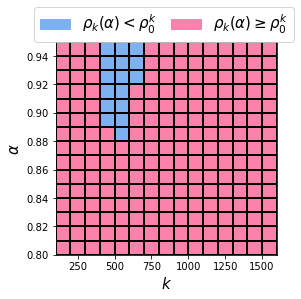

In [7]:
EG_SIM_KS = list(range(100, 1600 + 1, 100))
EG_SIM_ALPHAS = list(reversed([x/1000 for x in range(800, 950 + 1, 150 // 15)]))
EG_SIM_HPS = np.meshgrid(EG_SIM_KS, EG_SIM_ALPHAS)

# compute
eg_sim_improvements = np.array([
    eg_sim_radius(k, 1) > eg_sim_radius(k, alpha) for
    (k, alpha) in zip(EG_SIM_HPS[0].flatten(), EG_SIM_HPS[1].flatten())
]).reshape(EG_SIM_HPS[0].shape)
eg_sim_cs = [C['EG_SIM'](k) for k in EG_SIM_KS]

# plot
edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    EG_SIM_HPS[0], EG_SIM_HPS[1], eg_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<\rho_0^k$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq\rho_0^k$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 9', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1
)
plt.tight_layout(pad=0.1)
plt.savefig('appendix_bilinear_sweep_eg.png', format='png', dpi=200)
print(f'beta1: {EG_SIM_BETA1}, beta2: {EG_SIM_BETA2}')
print(f'=> c: {eg_sim_cs}')
print(f'=> a: {EG_SIM_ALPHAS}')
print(f'=> k: {EG_SIM_KS}')

# Optimization

In [8]:
np.random.seed(0)
torch.manual_seed(0)
x1_init = torch.randn(N, dtype=torch.double).cuda() * 10
x2_init = torch.randn(N, dtype=torch.double).cuda() * 10

def loss(x1, A, x2):
    return A.matmul(x1).dot(x2)

def distance(x1, x2):
    return ((x1.detach() ** 2).sum() + (x2.detach() ** 2).sum()).sqrt()

def run(opt_name, lr, k=None, alpha=None, alt=False, src='slow', dst='fast', log_every=500, niter=50000, momentum=0, eg_eta=None):
    x1 = nn.Parameter(x1_init.clone().cuda(), requires_grad=True)
    x2 = nn.Parameter(x2_init.clone().cuda(), requires_grad=True)
    x_avg = torch.cat([x1, x2])
    kwargs = {'lr': lr, 'momentum': momentum}
    if opt_name == 'ExtraSGD':
        kwargs['eta'] = eg_eta
    x1_optimizer = getattr(optimizers, opt_name)([x1], **kwargs)
    x2_optimizer = getattr(optimizers, opt_name)([x2], **kwargs)
    la = (
        optimizers.Lookahead(
            x1_optimizer, 
            x2_optimizer, 
            src=src,
            dst=dst,
            k=k, alpha=alpha,  
            device='cuda'
        ) if k and alpha is not None else None
    )
    
    aa_count = 0
    aa_residues = []
    last_history = []
    avg_history = []
    for t in tqdm(range(1, niter + 1)):
        if t % log_every == 1:
            last_history.append(distance(x1, x2).detach().cpu().numpy())
            avg_history.append(x_avg.norm(p=2).detach().cpu().numpy())
            
        if alt:
            # x1
            x1_optimizer.zero_grad()
            (loss(x1, A, x2)).backward()
            x1_optimizer.step()
            # x2
            x2_optimizer.zero_grad()
            (-loss(x1, A, x2)).backward()
            x2_optimizer.step()
        else:
            x1_prev = x1.clone()
            x2_prev = x2.clone()
            
            x1_optimizer.zero_grad()
            x2_optimizer.zero_grad()
            loss(x1, A, x2.detach()).backward()
            (-loss(x1.detach(), A, x2)).backward()
            if opt_name == 'ExtraSGD':
                x1_optimizer.extrapolation()
                x2_optimizer.extrapolation()
                x1_optimizer.zero_grad()
                x2_optimizer.zero_grad()
                loss(x1, A, x2.detach()).backward()
                (-loss(x1.detach(), A, x2)).backward()
            x1_optimizer.step()
            x2_optimizer.step()
        
        if la:
            la.step()
            
        with torch.no_grad():
            x_avg = x_avg * t/(t+1) + torch.cat([x1, x2]) / (t+1)
    return np.array(last_history), np.array(avg_history)

# GD_ALT + (NM) Optimization

In [ ]:
T = 50000
LR = 0.1
OPT = 'SGD'
ALT = True
K = 500
ALPHA = 0.25
NM = -0.5

nm_gd_alt_history, _ = run(OPT, lr=LR, alt=ALT, log_every=K, niter=T, momentum=NM)
gd_alt_history, _ = run(OPT, lr=LR, alt=ALT, log_every=K, niter=T)
la_gd_alt_history, _ = run(OPT, lr=LR, k=K, alpha=ALPHA, alt=ALT, log_every=K, niter=T)
la_nm_gd_alt_history, _ = run(OPT, lr=LR, k=K,  alpha=ALPHA, alt=ALT, log_every=K, niter=T, momentum=NM)

  0%|          | 0/50000 [00:00<?, ?it/s]/home_namjune/junsoo.ha/aistats-supp/optimizers/gd.py:106: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  p.data.add_(-group['lr'], d_p)
 83%|████████▎ | 41251/50000 [00:57<00:09, 930.44it/s] 

In [ ]:
plt.figure(figsize=(6, 4.5))

LINEWIDTH = 6

# custom x-axis ticker
matplotlib.pyplot.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, pos: f'{int(x // 1e3)}k' if x >= 1e3 else x
))

plt.plot(
    np.arange(1, T+1, step=K), gd_alt_history, 
    label=r'GD$_{Alt}$', 
    color=RED,
    linewidth=LINEWIDTH,
)
plt.plot(
    np.arange(1, T+1, step=K), nm_gd_alt_history, 
    label=r'GD$^{NM}_{Alt}$', 
    color=YELLOW,
    linewidth=LINEWIDTH,
)
plt.plot(
    np.arange(1, T+1, step=K), la_gd_alt_history, 
    label=r'LA-GD$_{Alt}$', 
    color=BLUE,
    linewidth=LINEWIDTH,
)
plt.plot(
    np.arange(1, T+1, step=K), la_nm_gd_alt_history, 
    label=r'LA-GD$^{NM}_{Alt}$', 
    color=GREEN,
    linewidth=LINEWIDTH,
)
plt.semilogy()
plt.xlabel('# of base dynamics steps', fontsize=20)
plt.ylabel('Distance to NE', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', ncol=2, fontsize=19, bbox_to_anchor=(1.015, 0.955), framealpha=0.7)
plt.tight_layout()
plt.savefig('appendix_bilinear_gd_progress.png', format='png', bbox_inches='tight', dpi=300)

# EG_SIM Optimization

In [ ]:
T = 50000
LR = 0.1
OPT = 'ExtraSGD'
ALT = False
K = 500
GOOD_ALPHA = 0.9
BAD_ALPHA = 0.1

good_la_eg_sim_history, _ = run(OPT, LR, K, GOOD_ALPHA, alt=ALT, log_every=K, niter=T)
bad_la_eg_sim_history, _ = run(OPT, LR, K, BAD_ALPHA, alt=ALT, log_every=K, niter=T)
base_eg_sim_history, _ = run(OPT, LR, alt=ALT, log_every=K, niter=T)

In [ ]:
plt.figure(figsize=(6, 4.5))

LINEWIDTH = 6

# custom x-axis ticker
matplotlib.pyplot.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda x, pos: f'{int(x // 1e3)}k' if x >= 1e3 else x
))

plt.plot(
    np.arange(1, T+1, step=K), base_eg_sim_history, 
    label=r'EG$_{Sim}$', 
    color=YELLOW,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=K), bad_la_eg_sim_history, 
    label=r'LA-EG$_{Sim}^{\dagger}$', 
    color=RED,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=K), good_la_eg_sim_history, 
    label=r'LA-EG$_{Sim}^*$', 
    color=BLUE,
    linewidth=LINEWIDTH
)

plt.semilogy()
plt.xlabel('# of base dynamics steps', fontsize=20)
plt.ylabel('Distance to NE', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', ncol=1, fontsize=19, bbox_to_anchor=(1.015, 1.015))
plt.tight_layout()
plt.savefig('appendix_bilinear_eg_progress.png', format='png', bbox_inches='tight', dpi=300)